# Imports and Data Generation

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.manifold import TSNE

two_pi = 2*pi

def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, two_pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

# Utility

In [134]:
len(np.intersect1d(np.where(y_ally == 1)[0], np.where(y_advr == 1)[0]))

16

In [128]:
def class_plot(X_input, aspect=True, title=False, orig=True, save=False):
    X_tsne = TSNE(n_components=2).fit_transform(X_input)
    X_pca = PCA(n_components=2).fit_transform(X_input)
    
    
    markers = ['x', 'o', 'x', 'o']
    colors = ['r', 'b']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    t1, t2 = '(a)', '(b)'
    for i in range(2):
        for j in range(2):
            tmp = X_pca[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
            ax1.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
    ax1.axis('equal')
    ax1.set_title(t1, y= -0.2)
    
    for i in range(2):
        for j in range(2):
            tmp = X_tsne[np.intersect1d(np.where(y_ally == i)[0], np.where(y_advr == j)[0])]
            ax2.scatter(tmp[:, 0], tmp[:, 1], c=colors[i], marker=markers[2*i+j])
    ax2.axis('equal')
    ax2.set_title(t2, y= -0.2)
    plt.show()
  

In [141]:
np.hstack((X, y_ally, y_advr))

array([[ 1.00000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.79529941e+00,  2.01298520e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.18957812e+00,  3.94355855e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 8.20763441e+00,  5.71268215e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.88966919e+00,  7.24792787e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.28964010e+00,  8.48644257e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.47305253e+00,  9.37752132e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.51427778e+00,  9.88468324e+00,  0.00000000e+00,
         0.00000000e+00],
       [-5.06491688e-01,  9.98716507e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.50652532e+00,  9.68077119e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.40394152e+00,  8.97804540e+00,  0.00000000e+00,
         0.00000000e+00],
       [-6.12105983e+00,  7.90775737e+00,  0.00000000e+00,
      

In [147]:
r = [10, 20]
n = [32, 32]
circles = circle_points(r, n)

ally_label = 0
advr_label = 0

X, y_ally, y_advr = [], [], []

for circle in circles:
    pos = circle[np.where(circle[:, 1]> 0)]
    neg = circle[np.where(circle[:, 1]<= 0)]
    X.append(pos)
    X.append(neg)
    y_ally.append([ally_label] * circle.shape[0])
    y_advr.append([advr_label] * pos.shape[0] + [advr_label+1] * neg.shape[0])
    ally_label += 1
    
X = np.concatenate(X, axis=0)
y_ally = np.concatenate(y_ally).reshape(-1, 1)
y_advr = np.concatenate(y_advr).reshape(-1, 1)
X.shape, y_ally.shape, y_advr.shape

((64, 2), (64, 1), (64, 1))

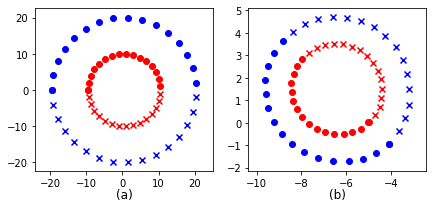

In [148]:
class_plot(X)

### Idea

Basically we are trying to learn represenations of any given data in another transformed axes where classification becomes easier along one label but becomes tougher along another one.

- Here we want to differentiate between the two circles while not being able to tell between the two semicircles

In [98]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

### Validation after scaling

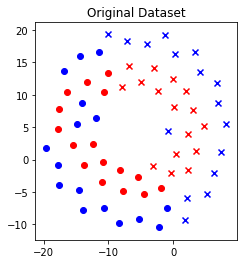

In [99]:
class_plot(X_normalized, title="Original Dataset")

# PCA

In [100]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_normalized)

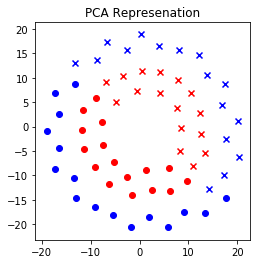

In [101]:
class_plot(X_pca, title='PCA Represenation')

# AutoEncoder

In [33]:
import torch

In [34]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        self.hidden_size = hidden_size
        
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        self.fc11 = torch.nn.Linear(self.hidden_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.hidden_size)
        self.sigmoid = torch.nn.Sigmoid()
        
        
        self.fc22 = torch.nn.Linear(self.hidden_size, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.sigmoid(self.fc11(self.sigmoid(self.fc1(x))))

    def decoder(self, y):
        return self.sigmoid(self.fc22(self.sigmoid(self.fc2(y))))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [35]:
auto_encoder = AutoEncoder(
    input_size=X_normalized.shape[1],
    encoding_dim=X_normalized.shape[1], 
    hidden_size=X_normalized.shape[1]*2
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.01)

In [149]:
X_torch = torch.Tensor(X_normalized)
y_ally_torch = torch.Tensor(y_ally.reshape(-1, 1))
y_advr_torch = torch.Tensor(y_advr.reshape(-1, 1))

epoch 	 Aencoder_train
0 	 0.08605692
1000 	 0.03835496
2000 	 0.00112713
3000 	 0.00074080
4000 	 0.00066497
5000 	 0.00063745
6000 	 0.00061441
7000 	 0.00059940
8000 	 0.00058886
9000 	 0.00058108
10000 	 0.00057559


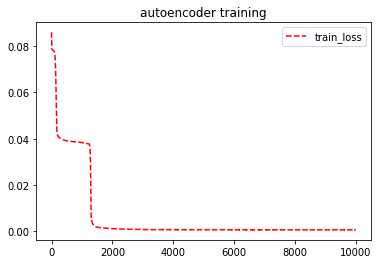

In [37]:
print("epoch \t Aencoder_train")

ae_epoch = []
ae_train = []

for epoch in range(10001):
    auto_encoder.train()
    ae_optimizer.zero_grad()
    
    X_torch_hat = auto_encoder(X_torch)
    ae_loss = criterion(X_torch_hat, X_torch)
    ae_loss.backward(retain_graph=True)
    ae_optimizer.step()
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
    ))
    

plt.plot(ae_epoch, ae_train, 'r--')
plt.legend(['train_loss'])
plt.title("autoencoder training")
plt.show()

In [38]:
X_autoencoded = auto_encoder.encoder(X_torch)

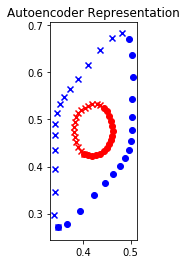

In [39]:
class_plot(X_autoencoded.detach().numpy(), title='Autoencoder Representation')

In [40]:
X_autodecoded = auto_encoder.decoder(X_autoencoded)

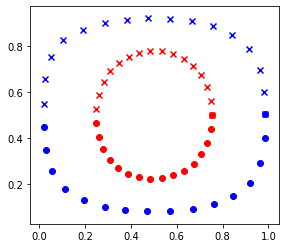

In [41]:
class_plot(X_autodecoded.detach().numpy())

# Privacy GAN

In [150]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.tanh(output)
        return output


class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output


class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [58]:
y_uniform_torch = torch.Tensor(np.ones((64,1))*0.5)

In [156]:
def train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True):
    encoding_dimension = X_pca.shape[1]
    encoder = Encoder(
        input_size=X_torch.shape[1], 
        hidden_size=encoding_dimension*8, 
        output_size=encoding_dimension*4)
    ally = Ally(
        input_size=encoding_dimension*4, 
        hidden_size=encoding_dimension*8, 
        output_size=y_ally_torch.shape[1])
    adversary = Adversary(
        input_size=encoding_dimension*4, 
        hidden_size=encoding_dimension*8, 
        output_size=y_advr_torch.shape[1])

    criterion = torch.nn.BCEWithLogitsLoss()
    kldiv = torch.nn.KLDivLoss()
    l1_loss = torch.nn.L1Loss()
    optimizer = torch.optim.Adam
    encd_optimizer = optimizer(encoder.parameters(), lr = lr_encd)
    ally_optimizer = optimizer(ally.parameters(), lr=lr_ally)
    advr_optimizer = optimizer(adversary.parameters(), lr=lr_advr)

    if debug:
        print("epoch \t encoder_train \t ally_train \t advr_train")

    g_epoch = []
    enc_train = []
    ally_train = []
    advr_train = []
    
    encoder.train()
    ally.train()
    adversary.train()

    for epoch in range(n_iter_gan):
        # set for training
        # Forward passv
        X_ganencoded = encoder(X_torch)
        y_ally_torch_hat = ally(X_ganencoded)
        y_advr_torch_hat = adversary(X_ganencoded)
        # Compute Loss
        ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
#         advr_loss = -criterion(y_advr_torch_hat, y_advr_torch)
        advr_loss = (32 - l1_loss(y_advr_torch_hat, y_advr_torch))/32
        encd_loss = alpha * ally_loss + (1- alpha) * advr_loss
        # Backward pass
        
        encd_optimizer.zero_grad()
        encd_loss.backward()
        encd_optimizer.step()

        for i in range(d_reps):
            X_ganencoded = encoder(X_torch)
            y_ally_torch_hat = ally(X_ganencoded)
            ally_optimizer.zero_grad()
            ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
            ally_loss.backward()
            ally_optimizer.step()
            
            X_ganencoded = encoder(X_torch)
            y_advr_torch_hat = adversary(X_ganencoded)
            advr_optimizer.zero_grad()
            advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
            advr_loss.backward()
            advr_optimizer.step()
        if plot:
            g_epoch.append(epoch)
            enc_train.append(encd_loss.item())
            ally_train.append(ally_loss.item())
            advr_train.append(advr_loss.item())
            
        if epoch%500!=0 and (debug or plot):
            continue

        if debug:
            print('{} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
                epoch, 
                encd_loss.item(),
                ally_loss.item(),
                advr_loss.item(),
            ))
        
        X_ganencoded = encoder(X_torch)
        class_plot(X_ganencoded.detach().numpy(), False)

    if plot:
        plt.plot(g_epoch, enc_train, 'r')
        plt.plot(g_epoch, ally_train, 'b')
        plt.plot(g_epoch, advr_train, 'g')
        plt.legend([
            'encoder train loss', 
            'ally train loss',
            'advr train loss',
        ])
        plt.title("GAN training")
        plt.show()            

        return encoder  

- maximize the divergence
- no dimensionality reduction here

epoch 	 encoder_train 	 ally_train 	 advr_train
0 	 0.84890497 	 0.71340704 	 0.70553505


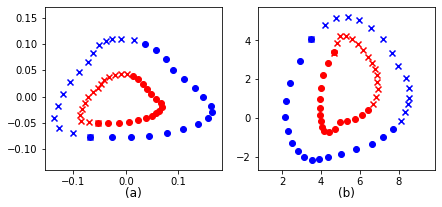

500 	 0.83192021 	 0.67944586 	 0.69371182


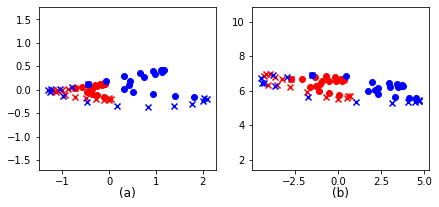

1000 	 0.79604971 	 0.60619819 	 0.66678077


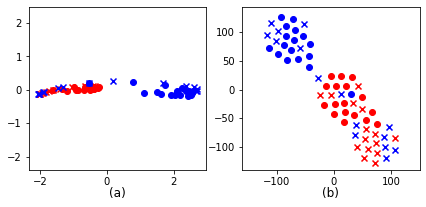

1500 	 0.75357819 	 0.52325106 	 0.70078272


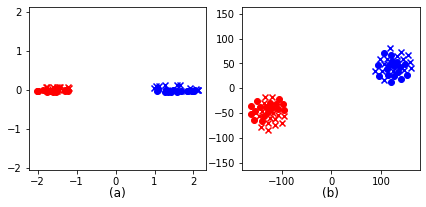

2000 	 0.74682570 	 0.50986934 	 0.69540846


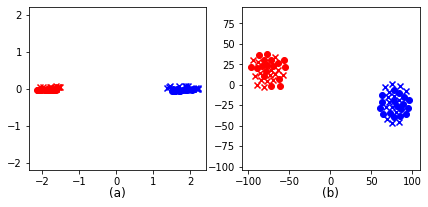

2500 	 0.74508548 	 0.50647044 	 0.69307411


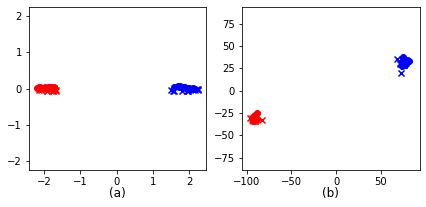

3000 	 0.74435556 	 0.50508338 	 0.69244683


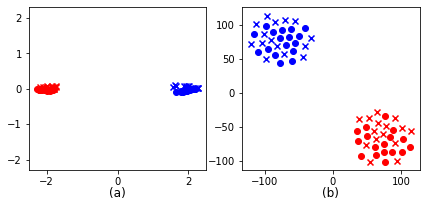

3500 	 0.74397898 	 0.50438070 	 0.69236922


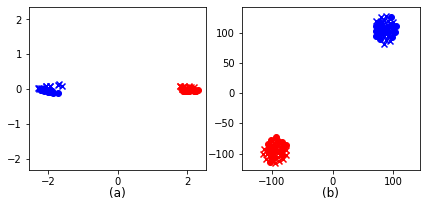

4000 	 0.74376059 	 0.50397694 	 0.69244969


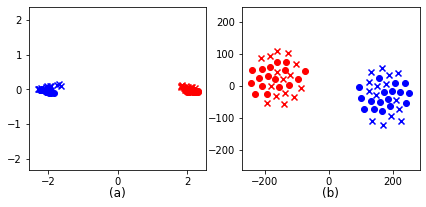

4500 	 0.74362671 	 0.50372958 	 0.69249624


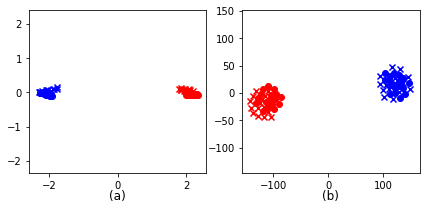

5000 	 0.74354398 	 0.50356895 	 0.69241142


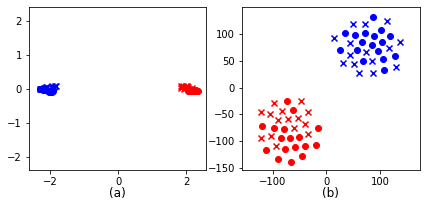

5500 	 0.74348861 	 0.50346547 	 0.69239360


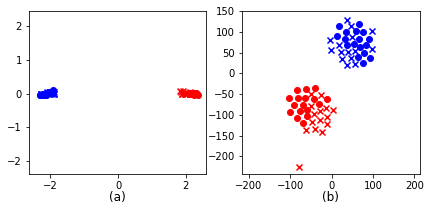

6000 	 0.74344933 	 0.50339627 	 0.69241410


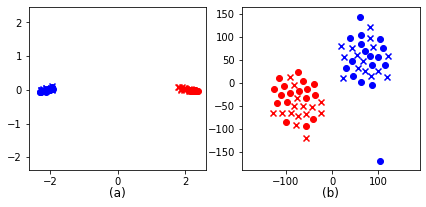

6500 	 0.74342334 	 0.50334406 	 0.69234586


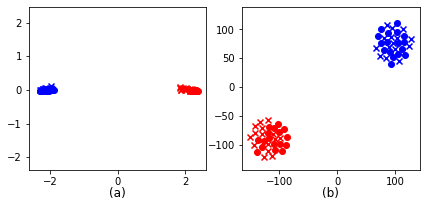

7000 	 0.74341100 	 0.50330579 	 0.69225883


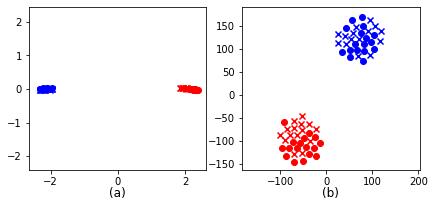

7500 	 0.74339539 	 0.50327957 	 0.69225484


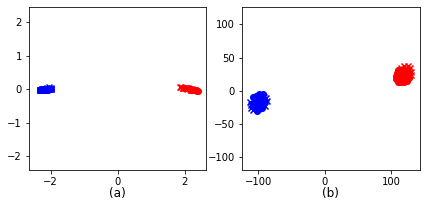

8000 	 0.74338531 	 0.50325984 	 0.69224995


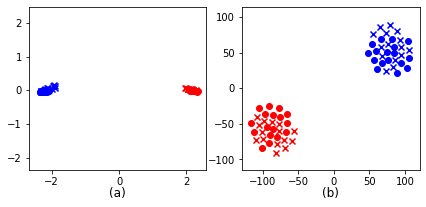

8500 	 0.74338001 	 0.50324583 	 0.69222194


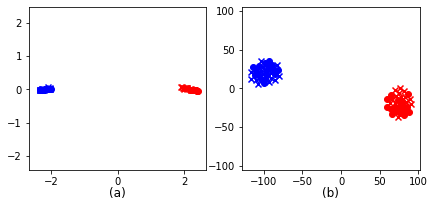

9000 	 0.74337566 	 0.50323546 	 0.69220805


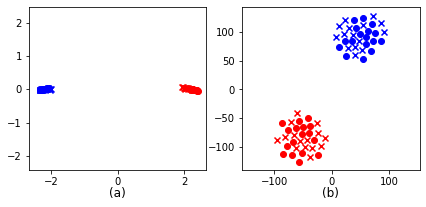

9500 	 0.74337232 	 0.50322783 	 0.69219995


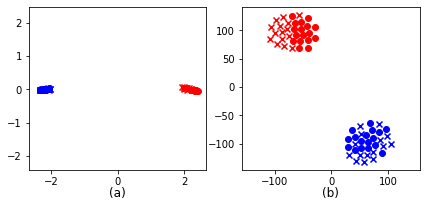

10000 	 0.74337006 	 0.50322211 	 0.69219196


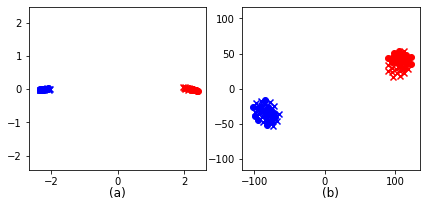

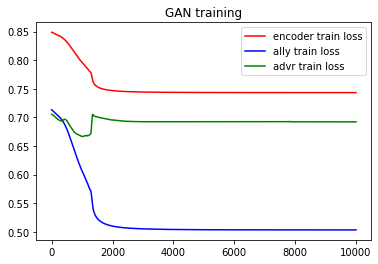

In [158]:
alpha = 0.5
lr_encd = 0.001
lr_ally = 0.0001
lr_advr = 0.0001
n_iter_gan = 10001
d_reps = 1

# alpha = 0.5
# lr_encd = 0.01
# lr_ally = 0.001
# lr_advr = 0.0001
# n_iter_gan = 5001
# d_reps = 2


encoder = train_privacy_gan(alpha, lr_encd, lr_ally, lr_advr, n_iter_gan, d_reps, plot=True, debug=True)

In [56]:
encoder.eval()
X_ganencoded = encoder(X_torch)

In [104]:
np.hstack((X_ganencoded.detach().numpy(), y_ally.reshape(-1, 1), y_advr.reshape(-1, 1)))

array([[-0.99999851, -0.99999994,  0.        ,  0.        ],
       [-0.9999997 , -1.        ,  0.        ,  0.        ],
       [-0.99999994, -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-1.        , -1.        ,  0.        ,  0.        ],
       [-0.99999994, -1.

# Training Independently

In [108]:
encoding_dimension = 2
encoder.eval()

Encoder(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

In [116]:
ally = Ally(
    input_size=encoding_dimension, 
    hidden_size=encoding_dimension, 
    output_size=y_ally_torch.shape[1])
ally_optimizer = optimizer(ally.parameters(), lr=0.001)

print("epoch \t ally_train")

ally.train()

n_iter = 10001
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_ally_torch_hat = ally(X_ganencoded)
    ally_optimizer.zero_grad()
    ally_loss = criterion(y_ally_torch_hat, y_ally_torch)
    ally_loss.backward()
    ally_optimizer.step()
    
    if epoch%1000!=0:
        continue

    print('{} \t {:.8f}'.format(
        epoch, 
        ally_loss.item(),
    ))
    

epoch 	 ally_train 	 advr_train
0 	 0.50912786
1000 	 0.25000000
2000 	 0.25000000
3000 	 0.25000000
4000 	 0.24999999
5000 	 0.25000000
6000 	 0.25000000
7000 	 0.25000000
8000 	 0.25000000
9000 	 0.25000000
10000 	 0.25000000


In [121]:
adversary = Adversary(
    input_size=encoding_dimension, 
    hidden_size=encoding_dimension, 
    output_size=y_advr_torch.shape[1])

advr_optimizer = optimizer(adversary.parameters(), lr=lr_ally)

print("epoch \t advr_train")

adversary.train()
    
for epoch in range(n_iter):
    X_ganencoded = encoder(X_torch)
    y_advr_torch_hat = adversary(X_ganencoded)
    advr_optimizer.zero_grad()
    advr_loss = criterion(y_advr_torch_hat, y_advr_torch)
    advr_loss.backward()
    advr_optimizer.step()
    
    if epoch%1000!=0:
        continue
    
    print('{} \t {:.8f}'.format(
        epoch, 
        advr_loss.item(),
    ))
    

epoch 	 advr_train
0 	 0.25045630
1000 	 0.25000000
2000 	 0.25000000
3000 	 0.25000000
4000 	 0.24999999
5000 	 0.25000000
6000 	 0.24999999
7000 	 0.24999999
8000 	 0.24999999
9000 	 0.24999999
10000 	 0.24999999


# DP

In [ ]:
def laplaceMechanism(x, epsilon):
    return x + np.random.laplace(0, 1.0/epsilon, x.shape)

In [ ]:
epsilons = [1, 10, 100, 1000]
for epsilon in epsilons:
    X_dp = laplaceMechanism(X_normalized, epsilon)

    class_plot(X_dp, title="DP at epsilon={}".format(epsilon))

In [ ]:
np.random.laplace(0, 1.0/100000, X_dp.shape)